In [1]:
# imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import dask.array as da
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import matplotlib.pyplot as plt

In [ ]:
# data paths
modis = '_'  # Folder with MODIS NPP data with gaps, clipped by ecoregions
modis_filled = '_'  # Folder with MODIS NPP gap-filled

steppe = '_.shp'  # shp-file with steppe ecoregions
steppe_filtered = '_.shp' # filtered shp-file with steppe ecoregions (without ecoregions, where NPP nodata < 40%)
ecoregions = '_.tif' # rastered polygons of ecoregions

In [8]:
# loading shp and grouping by ecoregions
gdf = gpd.read_file(steppe)
gdf = gdf.dissolve(by='ECO_NAME').reset_index()

# adding rasters with npp data
rasters_npp = sorted(glob.glob(os.path.join(modis, '*.tif')))
print(f'{len(rasters_npp)} npp files')
rasters_npp_filled = sorted(glob.glob(os.path.join(modis_filled, '*.tif')))
print(f'{len(rasters_npp_filled)} npp_filled files')

50 npp files
24 npp_filled files


In [ ]:
# NaN (values > 32760) stata (2024 year)
results = []

npp_2024 = [raster for raster in rasters_npp_filled if int(raster.split('/')[-1][-15:-11]) == 2024]
print("Selected rasters for 2024:", npp_2024)

for id, row in gdf.iterrows():
    ecoregion = row['ECO_NAME']  # ecoregion name
    geom = [row.geometry]  # grouped polygon geometry

    for raster_npp_filled in npp_2024:
        print(f"Processing {raster_npp_filled} for ecoregion {ecoregion}")
        try:
            with rasterio.open(raster_npp_filled) as raster:
                nodata_value = raster.nodata
                out_image, _ = rasterio.mask.mask(raster, geom, crop=True, nodata=nodata_value)
                out_image = out_image[0].astype(np.float32)
                out_image[out_image == nodata_value] = np.nan

                filledgaps_mask = out_image > 32760
                total_pixels = np.sum(~np.isnan(out_image))
                filledgaps_pixels = np.sum(filledgaps_mask)
                filledgaps_percent = (filledgaps_pixels / total_pixels) * 100

                results.append({
                    'ecoregion': ecoregion,
                    'year': 2024,
                    'total_pixels': total_pixels,
                    'filledgaps_pixels': filledgaps_pixels,
                    'filledgaps_percent': filledgaps_percent
                })
                print(f'{raster_npp_filled} processed for ecoregion {ecoregion}')

        except Exception as e:
            print(f'Error with {raster_npp_filled} for ecoregion {ecoregion}: {e}')

df_results = pd.DataFrame(results)
df_results.to_csv("npp_ecoregions_filledgaps_data_2024.csv", index=False)
print(df_results)

In [ ]:
print(df_results.sort_values(by='filledgaps_percent', ascending=False).head(5))
threshold = 40
df_filtered = df_results[df_results['filledgaps_percent'] <= threshold]
gdf_filtered = gdf.loc[gdf['ECO_NAME'].isin(df_filtered['ecoregion'])]

gdf_filtered.to_file(steppe_filtered) # saving filtered shp-file without ecoregions, where NPP nodata < 40%
print(f'Filtered shp: {steppe_filtered}')

In [ ]:
# zonal statistics 
sheets = pd.read_excel('_\zonal_stat.xls', sheet_name=None, index_col='ZONE_CODE') # statistics for each year from analysis in ArcGIS
columns = ['ECO_NAME', 'MIN', 'MAX', 'MEAN', 'STD', 'MEDIAN', 'PCT5', 'PCT95']
years = list(range(2001, 2025))
zonal_stat = None 

for i, (sheet_name, df) in enumerate(sheets.items()):
    year = years[i]
    df_selected = df[columns]

    if i == 0:
        df_renamed = df_selected.rename(columns={col: f"{col}_{year}" for col in df_selected.columns if col != 'ECO_NAME'}) # combining all years to one table
    else:
        df_renamed = df_selected.drop(columns='ECO_NAME', errors='ignore').rename(columns={col: f"{col}_{year}" for col in df_selected.columns})

    if zonal_stat is None:
        zonal_stat = df_renamed
    else:
        zonal_stat = pd.concat([zonal_stat, df_renamed], axis=1)

print('zonal stat is combined')

zonal stat is combined


In [ ]:
zonal_stat.to_excel('_\zonal_stat_combined.xlsx')
zonal_stat.head()

,ECO_NAME,MIN_2001,MAX_2001,MEAN_2001,STD_2001,MEDIAN_2001,PCT5_2001,PCT95_2001,MIN_2002,MAX_2002,...,MEDIAN_2023,PCT5_2023,PCT95_2023,MIN_2024,MAX_2024,MEAN_2024,STD_2024,MEDIAN_2024,PCT5_2024,PCT95_2024
ZONE_CODE,,,,,,,,,,,,,,,,,,,,,
1,Khangai Mountains alpine meadow,0.0205,0.4831,0.180304,0.054590,0.1785,0.0950,0.2724,0.0179,0.4409,...,0.2013,0.1043,0.3134,0.0338,0.6586,0.246838,0.069527,0.2435,0.1358,0.3626
2,Selenge-Orkhon forest steppe,0.0259,0.6557,0.261548,0.087541,0.2544,0.1325,0.4217,0.0234,0.6069,...,0.2958,0.1508,0.5203,0.0313,0.7643,0.335870,0.107513,0.3278,0.1775,0.5173
3,Kopet Dag woodlands and forest steppe,0.0001,0.3917,0.077079,0.037758,0.0703,0.0312,0.1434,0.0001,0.4843,...,0.0719,0.0333,0.1710,0.0010,0.5278,0.107015,0.057150,0.0931,0.0416,0.2103
4,Eastern Himalayan alpine shrub and meadows,0.0001,1.9256,0.221412,0.273761,0.1079,0.0286,0.9002,0.0001,1.9849,...,0.1196,0.0310,0.8547,0.0008,1.8737,0.237442,0.251233,0.1387,0.0377,0.8216
5,Great Lakes Basin desert steppe,0.0132,0.6841,0.120841,0.083049,0.0917,0.0483,0.3058,0.0157,0.6101,...,0.0994,0.0536,0.3112,0.0165,0.7111,0.155284,0.095780,0.1207,0.0626,0.3685


C:\Users\varva\AppData\Local\Temp\ipykernel_16108\3707253578.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']


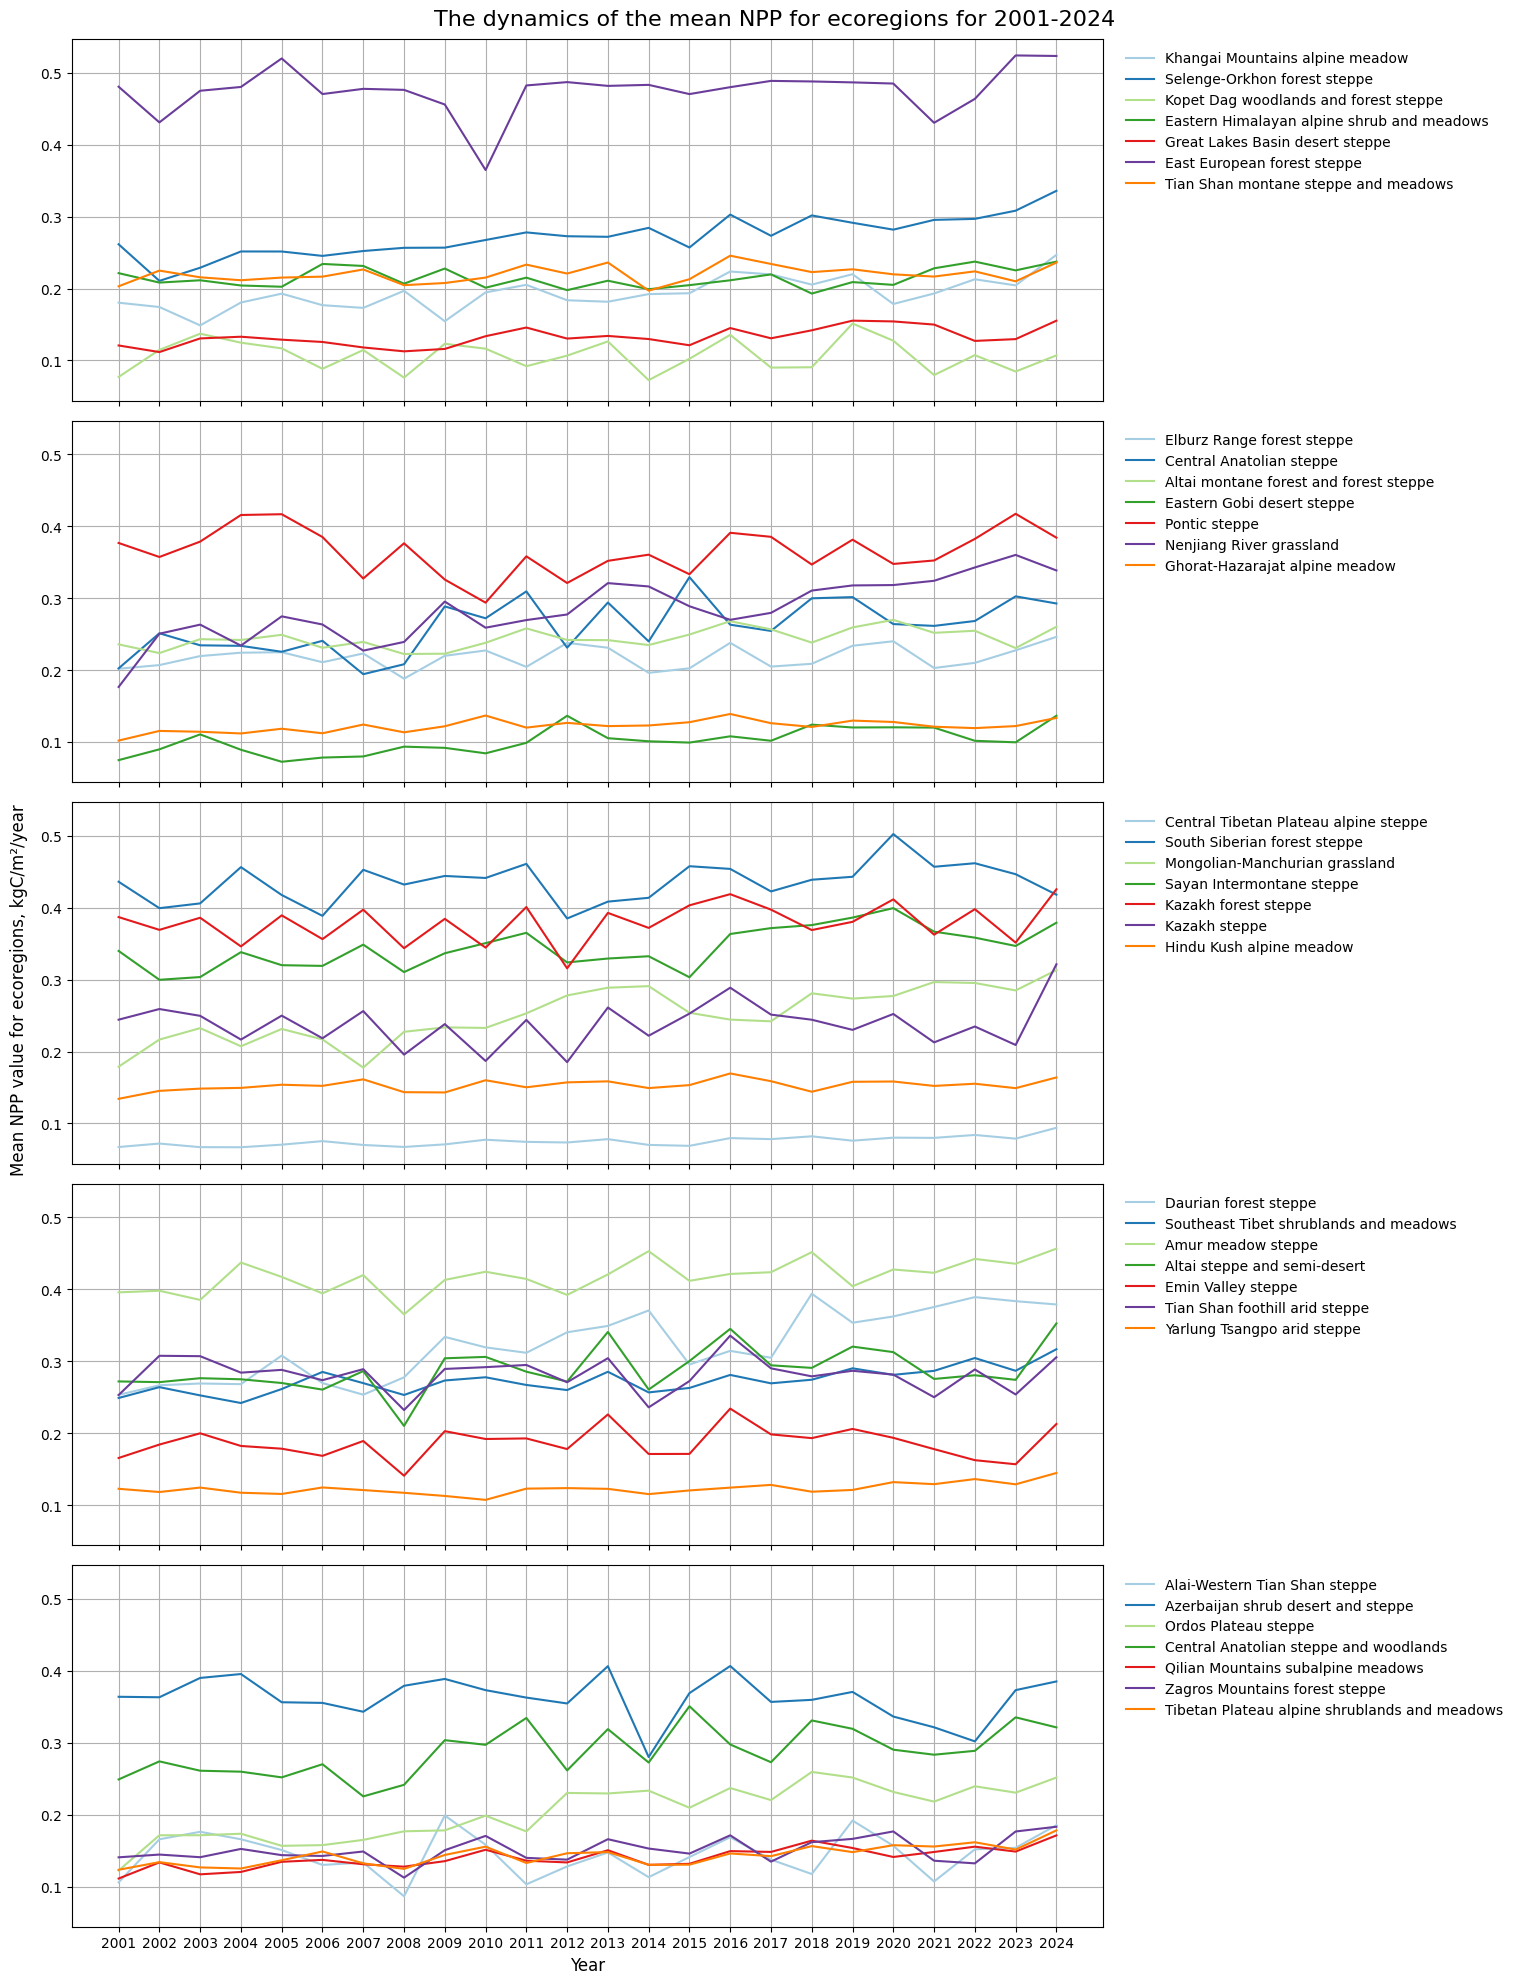

In [14]:
# visualization of the dynamics of the mean NPP value for ecoregions for 2001-2024
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.ravel()

mean_columns = [f'MEAN_{year}' for year in range(2001, 2025)]
zonal_stat_mean = zonal_stat[mean_columns]
zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']
unique_eco_names = zonal_stat_mean['ECO_NAME'].unique()
num_plots = len(unique_eco_names)
plots_per_subplot = num_plots // 5 + (num_plots % 5 > 0)

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#E31A1C', '#6A3D9A', '#FF7F00', '#6A3D9A']

for i, ax in enumerate(axs):
    start_idx = i * plots_per_subplot
    end_idx = min((i + 1) * plots_per_subplot, num_plots)
    eco_names_subset = unique_eco_names[start_idx:end_idx]
    legend_data = {}

    for j, er in enumerate(eco_names_subset):
        data = zonal_stat_mean[zonal_stat_mean['ECO_NAME'] == er]
        legend_data[er], = ax.plot(range(2001, 2025), data.iloc[0, :-1], label=er, color=colors[j])

    ax.grid(True)
    if i == 4:  
        ax.set_xlabel('Year', fontsize=12)
        ax.set_xticks(range(2001, 2025))
    else:
        ax.set_xticks([])

    ax.legend(legend_data.values(), legend_data.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle('The dynamics of the mean NPP for ecoregions for 2001-2024', fontsize=16, x=0.5, y=0.99)
fig.text(-0.01, 0.5, 'Mean NPP value for ecoregions, kgC/m²/year', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

Same for the NEE data in NetCDF

In [ ]:
# zonal statistics 
sheets = pd.read_excel('_\gcas_zonal_stat.xls', sheet_name=None, index_col='ZONE_CODE')
columns = ['ECO_NAME', 'MIN', 'MAX', 'MEAN', 'STD', 'MEDIAN', 'PCT5', 'PCT95']
years = list(range(2010, 2020))
zonal_stat = None

for i, (sheet_name, df) in enumerate(sheets.items()):
    year = years[i]
    df_selected = df[columns]

    if i == 0:
        df_renamed = df_selected.rename(columns={col: f"{col}_{year}" for col in df_selected.columns if col != 'ECO_NAME'})
    else:
        df_renamed = df_selected.drop(columns='ECO_NAME', errors='ignore').rename(columns={col: f"{col}_{year}" for col in df_selected.columns})

    if zonal_stat is None:
        zonal_stat = df_renamed
    else:
        zonal_stat = pd.concat([zonal_stat, df_renamed], axis=1)

print('zonal stat is combined')

zonal stat is combined


In [ ]:
zonal_stat.to_excel('_\gcas_zonal_stat_combined.xlsx')
zonal_stat.head()

,ECO_NAME,MIN_2010,MAX_2010,MEAN_2010,STD_2010,MEDIAN_2010,PCT5_2010,PCT95_2010,MIN_2011,MAX_2011,...,MEDIAN_2018,PCT5_2018,PCT95_2018,MIN_2019,MAX_2019,MEAN_2019,STD_2019,MEDIAN_2019,PCT5_2019,PCT95_2019
ZONE_CODE,,,,,,,,,,,,,,,,,,,,,
1,Khangai Mountains alpine meadow,-33.082447,-21.101957,-27.302289,4.545320,-28.229435,-32.686932,-21.243986,-44.187740,-13.708731,...,-17.350380,-23.662035,-4.604546,-38.171169,-21.129156,-25.928370,5.946212,-23.008314,-35.682983,-21.355577
2,Selenge-Orkhon forest steppe,-55.302055,15.000436,-19.566662,20.453570,-22.804268,-47.321659,13.976857,-40.183472,23.964233,...,-29.510715,-78.464164,0.041993,-66.215408,43.556004,-17.166521,23.400877,-19.296274,-46.029902,17.461306
3,Kopet Dag woodlands and forest steppe,-9.848472,-1.906319,-6.933555,3.007523,-7.989715,-9.614655,-2.773831,-0.191928,5.326049,...,1.014334,-3.035860,3.785547,-33.386238,-16.391447,-23.943684,6.138744,-22.998525,-32.004034,-17.206555
4,Eastern Himalayan alpine shrub and meadows,-45.033794,-6.465094,-17.982049,14.165008,-12.071593,-39.733883,-6.733180,-127.946335,-46.725555,...,-6.593236,-27.589496,-1.004750,-68.851219,24.890461,-2.931240,35.941423,21.656452,-57.903967,24.264981
5,Great Lakes Basin desert steppe,-42.155003,0.237811,-11.710217,12.713203,-5.819996,-32.478490,0.237811,-23.824877,0.095501,...,-2.902229,-27.535859,2.495255,-58.402889,0.390194,-10.280420,14.739306,-5.313618,-39.496154,-0.111813


C:\Users\varva\AppData\Local\Temp\ipykernel_16108\861416981.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']


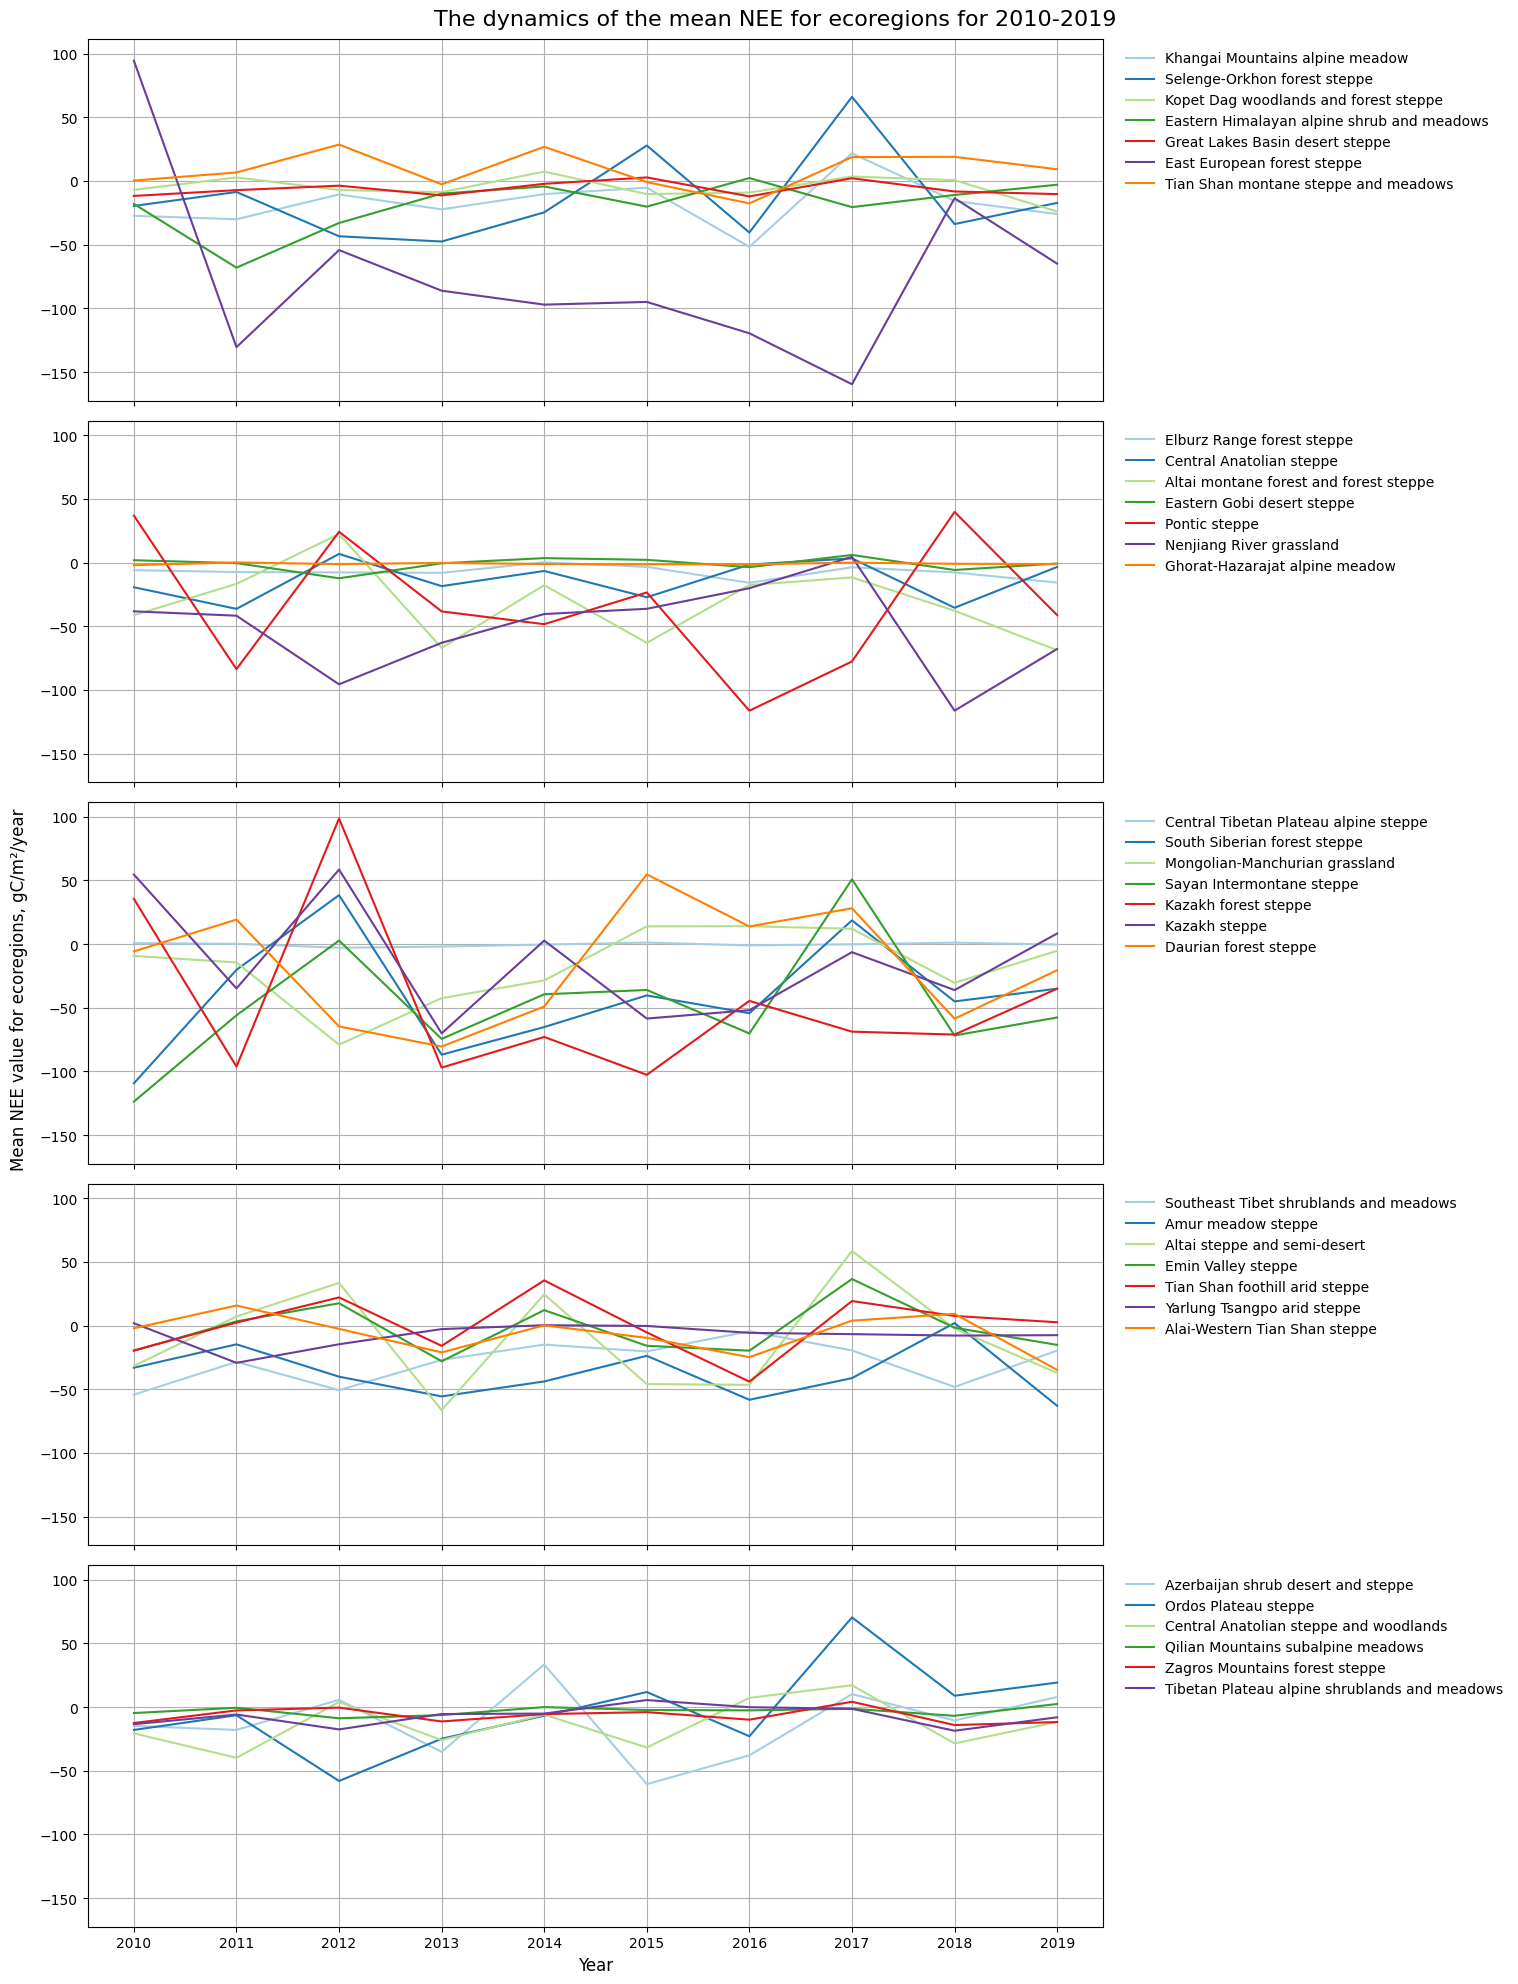

In [20]:
# visualization of the dynamics of the mean NEE value for ecoregions for 2010-2019
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)
axs = axs.ravel()

mean_columns = [f'MEAN_{year}' for year in range(2010, 2020)]
zonal_stat_mean = zonal_stat[mean_columns]
zonal_stat_mean['ECO_NAME'] = zonal_stat['ECO_NAME']
unique_eco_names = zonal_stat_mean['ECO_NAME'].unique()
num_plots = len(unique_eco_names)
plots_per_subplot = num_plots // 5 + (num_plots % 5 > 0)

colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#E31A1C', '#6A3D9A', '#FF7F00', '#6A3D9A']

for i, ax in enumerate(axs):
    start_idx = i * plots_per_subplot
    end_idx = min((i + 1) * plots_per_subplot, num_plots)
    eco_names_subset = unique_eco_names[start_idx:end_idx]
    legend_data = {}

    for j, er in enumerate(eco_names_subset):
        data = zonal_stat_mean[zonal_stat_mean['ECO_NAME'] == er]
        legend_data[er], = ax.plot(range(2010, 2020), data.iloc[0, :-1], label=er, color=colors[j])

    ax.grid(True)
    if i == 4:  
        ax.set_xlabel('Year', fontsize=12)
        ax.set_xticks(range(2010, 2020))
    else:
        ax.set_xticks([])

    ax.legend(legend_data.values(), legend_data.keys(), bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle('The dynamics of the mean NEE for ecoregions for 2010-2019', fontsize=16, x=0.5, y=0.99)
fig.text(-0.01, 0.5, 'Mean NEE value for ecoregions, gC/m²/year', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()